## Time to get your hands dirty! Gamma Ray Bursts.
Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

In [47]:
# LECTURE 14: GAMMA RAY BURST

# > T90: Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%. 
# This parameter depends on the efficiency with which photons of various energies can be observed, thus the detector. 
# > FLUENCE: The time integrated total energy per unit surface. Observed value strongly depends on the energy band and thus the detector.  
# > REDSHIFT: Distance to the GRB.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import requests

# K-Means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

# Mean-shift 
from sklearn.cluster import MeanShift
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth 

In [49]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


/tmp/ipykernel_5158/3469994911.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


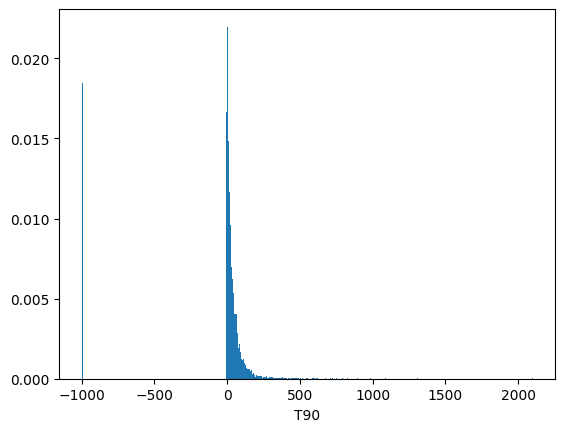

In [50]:
T90 = np.array(data[6], dtype='float')
T90_er = np.array(data[7], dtype='float')

plt.hist(T90, bins= int(len(T90)/20), density=True)
plt.xlabel('T90')
plt.show()

fluence = np.array(data[9], dtype='float')
fluence_er = np.array(data[10], dtype='float')

# flag = -999 -> value not measured
# clear dataset with boolean mask -> exlude every measurement that includes -999
data_new = np.column_stack((T90, fluence))
mask = ~(data_new==-999).any(axis=1)

data_clear = data_new[mask]

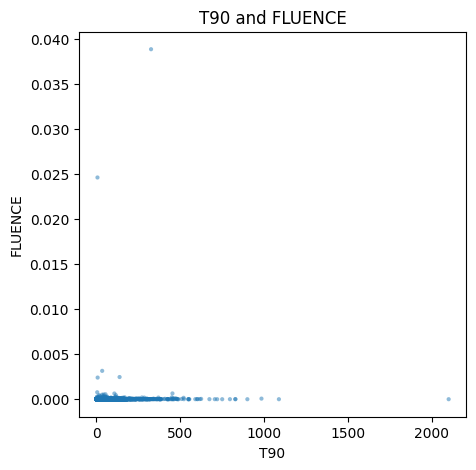

In [51]:
# > CLUSTERING WITH K-MEANS METHOD -> parametric (have to specify the number of clusters)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.scatter(data_clear[:, 0], data_clear[:, 1], marker=".", alpha=0.5, edgecolors='none')
ax.set_xlabel('T90')
ax.set_ylabel('FLUENCE')
plt.title("T90 and FLUENCE")
plt.show()

[ 48.64    1.024  48.641 ...   3.136 208.576   5.184]


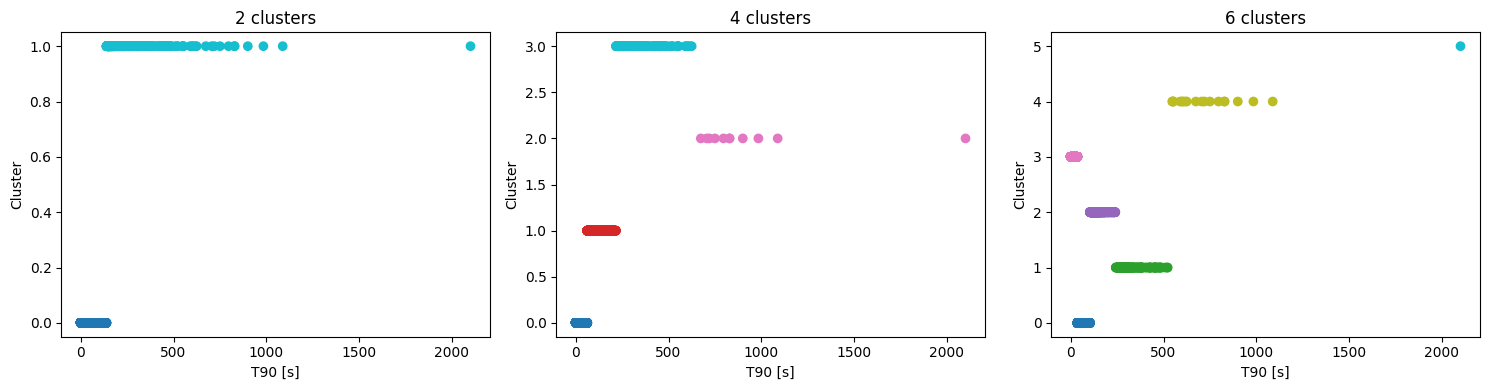

In [52]:
# CLUSTERING OF T90 DATA
T90 = np.array(data_clear[:, 0], dtype='float')
print(T90)

T90_2D =  T90.reshape(-1, 1) # column 

n = [2, 4, 6]
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

for i in range(3):
    clf = KMeans(n_clusters=n[i], n_init='auto')
    clf.fit(T90_2D)

    centers = clf.cluster_centers_ # location of the clusters
    labels = clf.predict(T90_2D) # labels for each of the points

    ax = axes[i]
    scatter = ax.scatter(T90, labels, c=labels, cmap='tab10')
    ax.set_title(f"{n[i]} clusters")
    ax.set_xlabel("T90 [s]")
    ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()

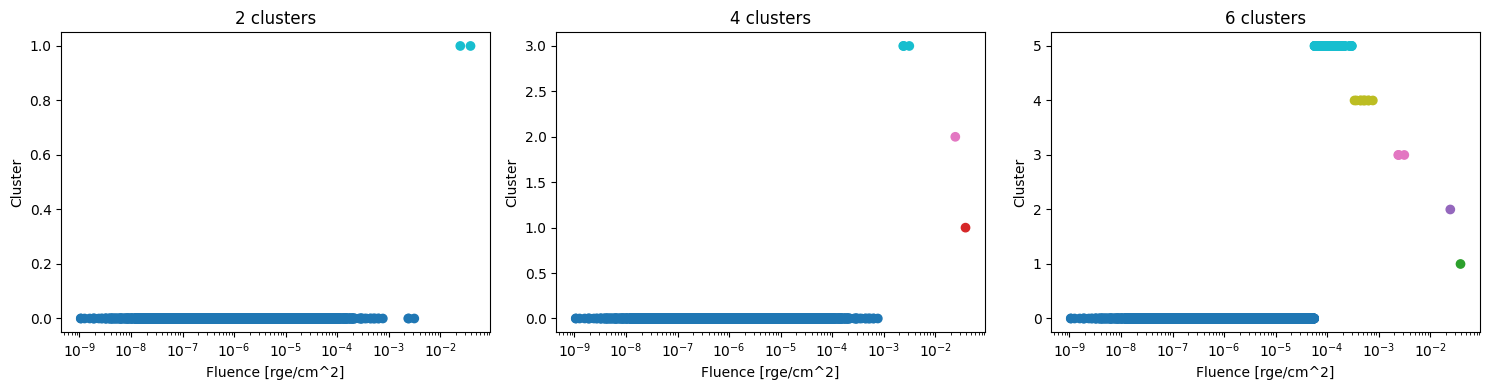

In [53]:
# CLUSTERING OF FLUENCE DATA
FLUENCE = np.array(data_clear[:, 1], dtype='float')
print()

FLUENCE_2D =  FLUENCE.reshape(-1, 1) # column 

n = [2, 4, 6]
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

for i in range(3):
    clf = KMeans(n_clusters=n[i], n_init='auto')
    clf.fit(FLUENCE_2D)

    centers = clf.cluster_centers_
    labels = clf.predict(FLUENCE_2D)

    ax = axes[i]
    scatter = ax.scatter(FLUENCE, labels, c=labels, cmap='tab10')
    ax.set_title(f"{n[i]} clusters")
    ax.set_xlabel("Fluence [rge/cm^2]") # 1 erg/cm² = 10^−7 joule per square centimeter
    ax.set_ylabel("Cluster")
    ax.set_xscale('log')  # logaritmic scale 

plt.tight_layout()
plt.show()

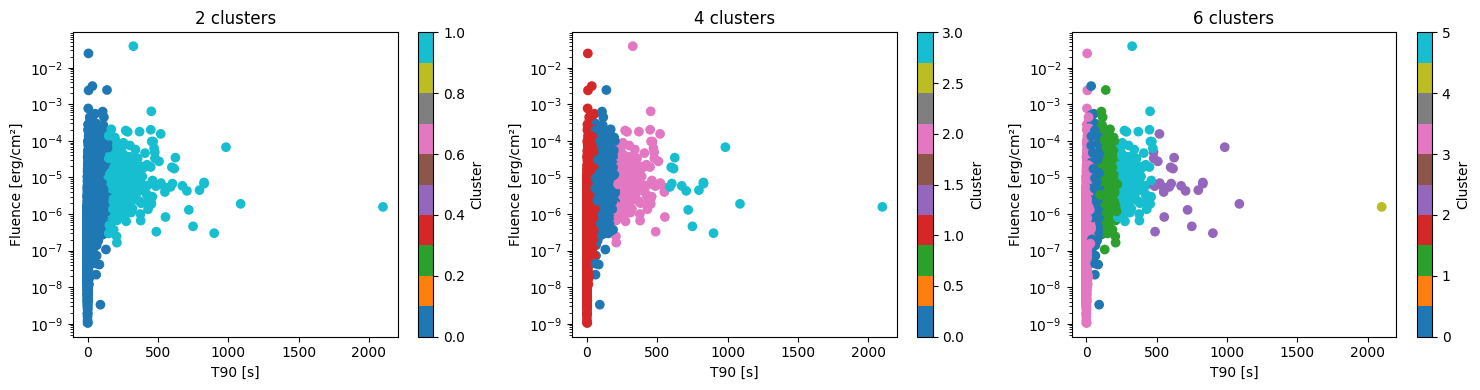

In [54]:
# 2D CLUSERING OF FLUENCE AND T90
n = [2, 4, 6]
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

for i in range(3):
    clf = KMeans(n_clusters=n[i], n_init='auto')
    clf.fit(data_clear)
    labels = clf.labels_

    ax = axes[i]
    scatter = ax.scatter(data_clear[:, 0], data_clear[:, 1], c=labels, cmap='tab10')
    ax.set_xlabel("T90 [s]")
    ax.set_ylabel("Fluence [erg/cm²]")
    ax.set_title(f"{n[i]} clusters")
    ax.set_yscale('log')  # logaritmic scale

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("Cluster")

plt.tight_layout()
plt.show()

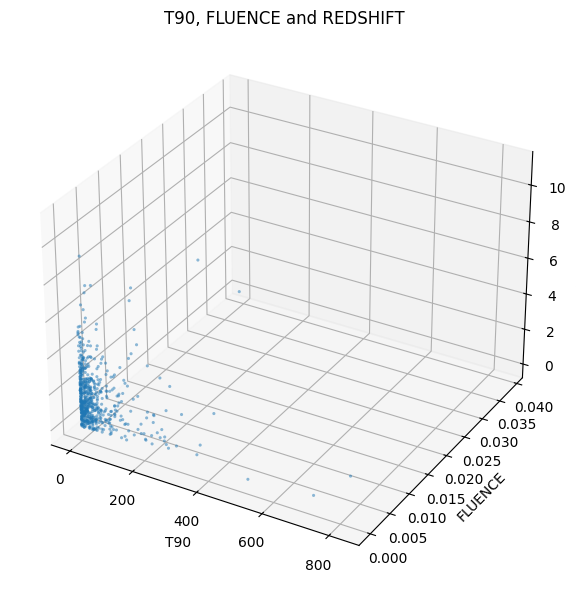

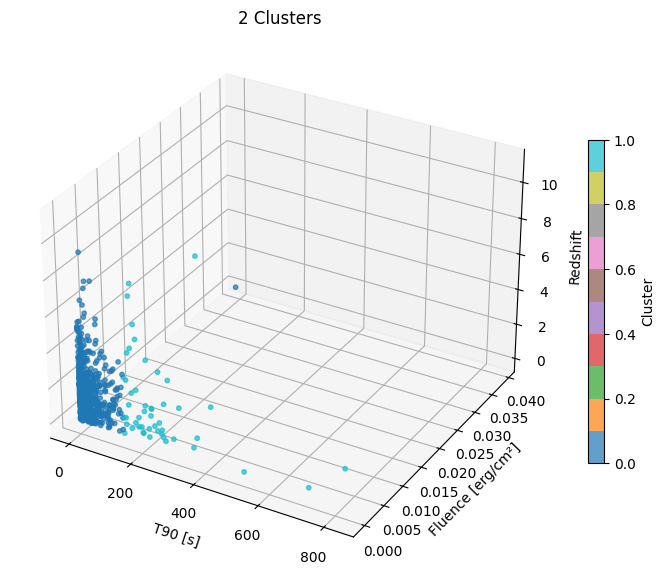

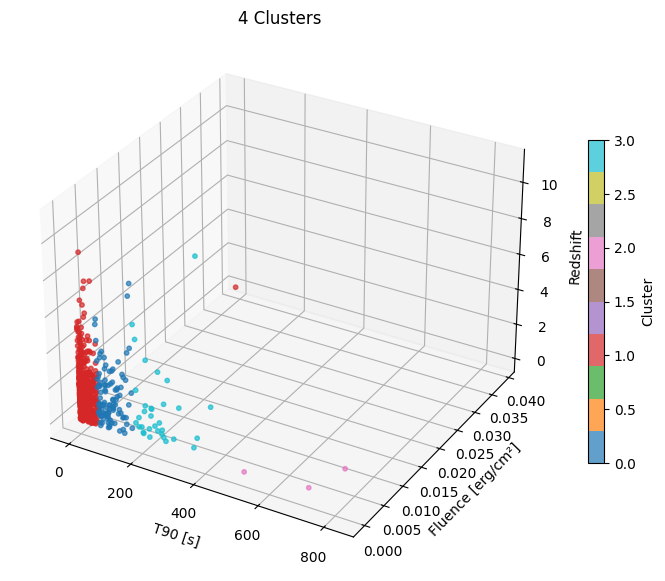

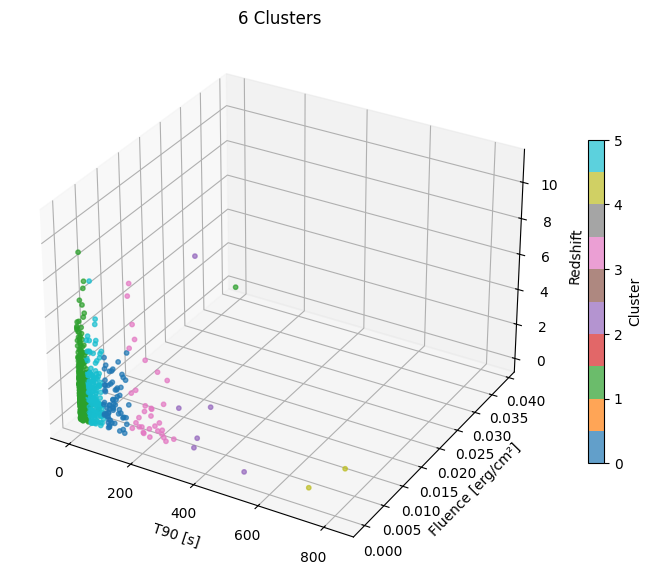

In [55]:
# REDSHIFT, FLUENCE, T90 CLUSTERING
redshift = np.array(data[11], dtype='float')

min_len = min(len(T90), len(fluence), len(redshift))
data_new = np.column_stack((T90[:min_len], fluence[:min_len], redshift[:min_len]))
mask = ~(data_new==-999).any(axis=1)
data_clear = data_new[mask]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')  

ax.scatter(data_clear[:, 0], data_clear[:, 1], data_clear[:, 2], marker=".", alpha=0.5, edgecolors='none')

ax.set_xlabel('T90')
ax.set_ylabel('FLUENCE')
ax.set_zlabel('REDSHIFT') 

plt.title("T90, FLUENCE and REDSHIFT")
plt.tight_layout()
plt.show()

n = [2, 4, 6]

for i in range(3):
    fig = plt.figure(figsize=(10, 7)) 
    ax = fig.add_subplot(111, projection='3d')  

    clf = KMeans(n_clusters=n[i], n_init='auto')
    clf.fit(data_clear)
    labels = clf.labels_

    scatter = ax.scatter(data_clear[:, 0], data_clear[:, 1], data_clear[:, 2],
                         c=labels, cmap='tab10', s=10, alpha=0.7)
    
    ax.set_xlabel("T90 [s]")
    ax.set_ylabel("Fluence [erg/cm²]")
    ax.set_zlabel("Redshift")

    ax.set_title(f"{n[i]} Clusters")

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label("Cluster")

    plt.show()  

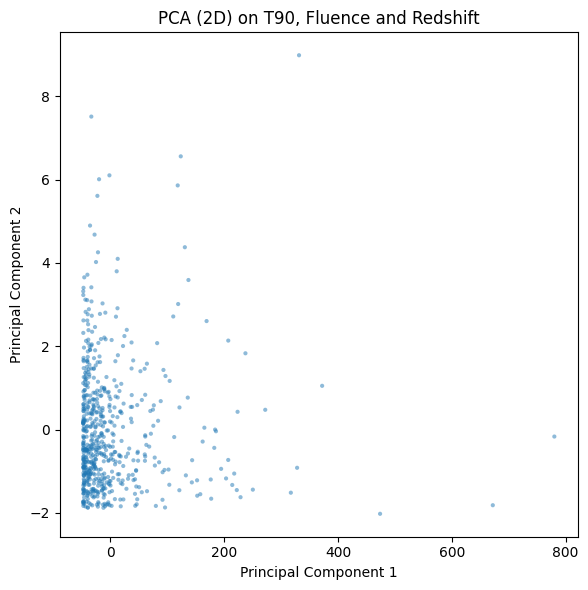

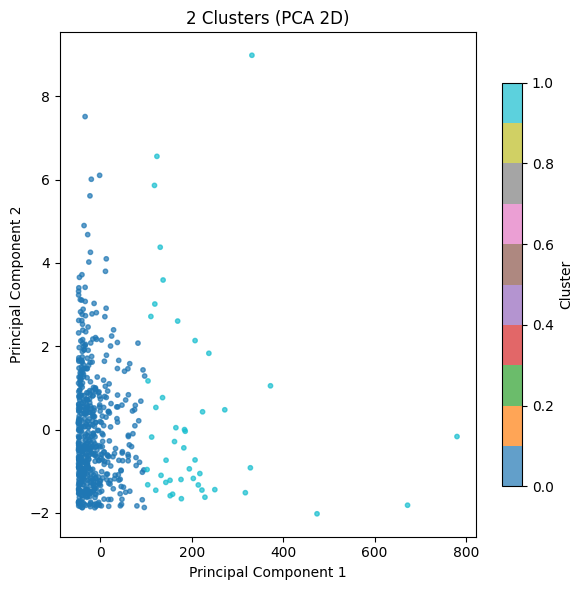

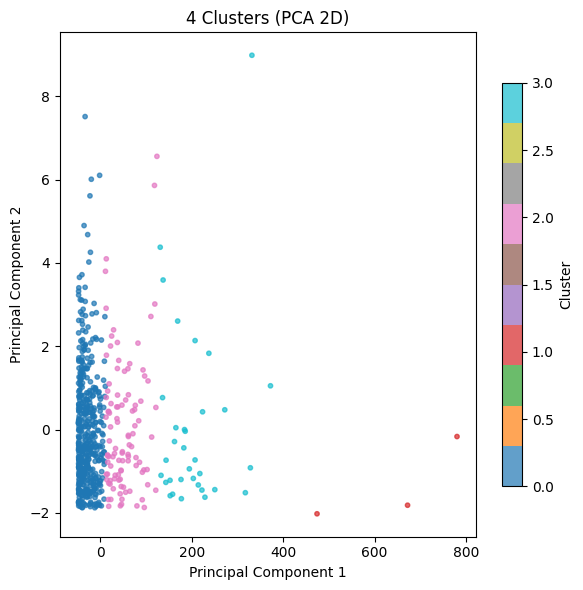

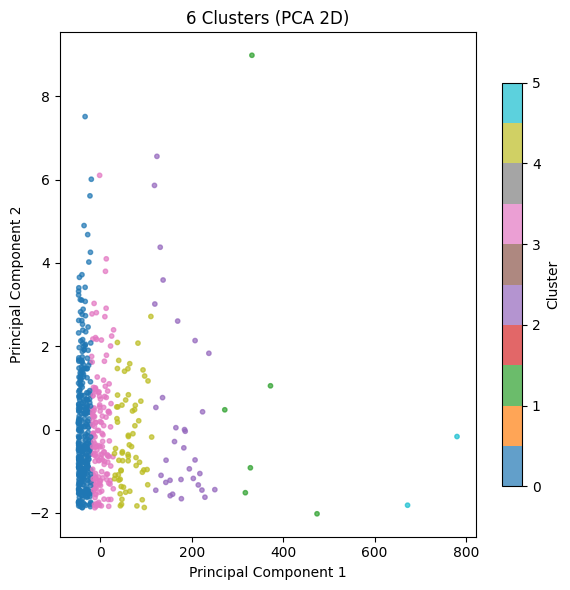

In [56]:
# REDSHIFT, FLUENCE, T90 CLUSTERING down to 2 dimention with PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_clear)

# Visualizzazione dei dati ridotti con PCA
fig = plt.figure(figsize=(6, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker=".", alpha=0.5, edgecolors='none')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("PCA (2D) on T90, Fluence and Redshift")
plt.tight_layout()
plt.show()

# Clustering + grafici per 2, 4, 6 cluster su dati PCA 2D
n = [2, 4, 6]

for i in range(3):
    fig = plt.figure(figsize=(6, 6))  # nuova figura per ogni clustering
    ax = fig.add_subplot(111)

    clf = KMeans(n_clusters=n[i], n_init='auto')
    clf.fit(data_reduced)
    labels = clf.labels_

    scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1],
                         c=labels, cmap='tab10', s=10, alpha=0.7)

    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title(f"{n[i]} Clusters (PCA 2D)")

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label("Cluster")

    plt.tight_layout()
    plt.show()

 Estimated bandwidth: 1.005
[-1  0  1  2  3  4  5  6  7  8  9]
1.0052079410284753
number of estimated clusters : 10


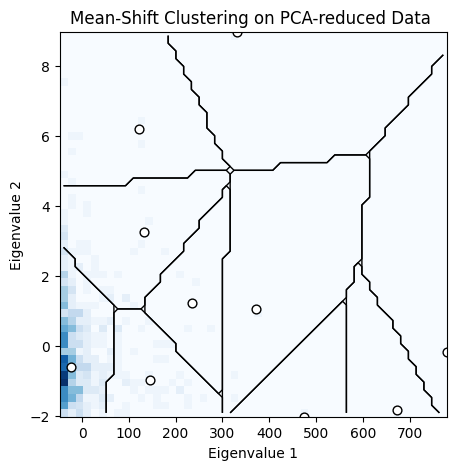

In [58]:
# > MEAN-SHIFT CLUSTERING METHOD -> chooses automaticly the number of clusters
# Transform data so that the mean of each column is 0 and the sigma is 1 -> features are comparable in scale
scaler_2D = preprocessing.StandardScaler()
scaled_data_2D = scaler_2D.fit_transform(data_reduced)

bandwidth = estimate_bandwidth(scaled_data_2D, quantile=0.3, n_samples=500) # bandwidth -> radius of the sphere that contains the data used to find increasing gradient direction
print(f" Estimated bandwidth: {bandwidth:.3f}")

ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, # Initial grid for points -> improve performance
               cluster_all=False) # Points that are not close to any center are not assigned to a cluster
ms.fit(scaled_data_2D)

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram of the input
H, xedges, yedges = np.histogram2d(data_reduced[:, 0], data_reduced[:, 1], 50)

# Plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')

# Plot cluster centers
cluster_centers = scaler_2D.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# Plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])
Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler_2D.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors='k')

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.title("Mean-Shift Clustering on PCA-reduced Data ")
plt.show()